<a href="https://colab.research.google.com/github/venkatacrc/Notes/blob/master/ML_GCP/End_to_End_ML_TF_GCP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##End to End Machine Learning with TensorFlow on GCP
Source: [End to End Machine Learning with TensorFlow on GCP](https://www.coursera.org/learn/end-to-end-ml-tensorflow-gcp)

1. Explore, visualize a dataset
1. Create sampled dataset
1. Develop a Tensorflow model
1. Create training and evaluaton datasets
1. Execute training
1. Deploy prediction service
1. Invoke ML predictions

Distributed Tensorflow on Cloud ML Engine

Components | Description
---|---
tf.estimator| High level API for distributed training
tf.layers, tf.losses, tf.metrics| Components useful when building cusom NN models
Core Tensorflow(Python) | Python API gives you full control 
Core Tensorflow(C++) | C++ API is quite low level
CPU, GPU, TPU, Android| TF runs on different hardware

When the data can't fit into memory, batching and distribution become important.

Main parts:
1. Big Data
1. Effective feature engineering
1. Model Architectures

Need autosclaing based on number of prediction client queries.

Inputs $\Rightarrow$ Pre-processing $\Rightarrow$ Feture Engineering $\Rightarrow$ Train Model(Hyper-parameter tuning) $\Rightarrow$ TF Model $\Rightarrow$ Deploy Web Application $\leftarrow$ REST API call with input variables $-$ Clients

**Training-Serving Skew**: The difference between what it was trainined on and what it's being presented at prediction time.

Cloud ML provides repeatable, scalable, and tuned.

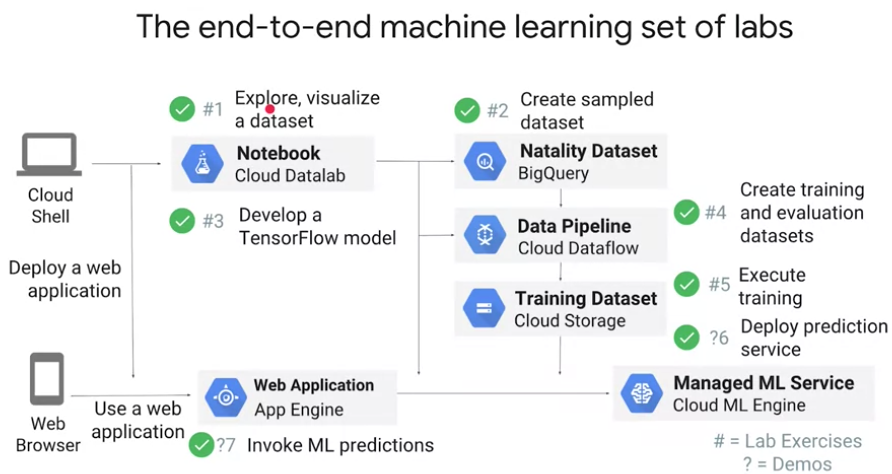


###Explore the data

https://cloud.google.com/blog/products/gcp/an-in-depth-look-at-googles-first-tensor-processing-unit-tpu

BigQuery is a serverless data warehouse
1. Interative analysis of petabyte scale databases
1. Familiar, SQL 2011 query language and functions
1. Many ways to ingest, transform, load, export data to/from BigQuery
1. Nested and repeated fields, user-defined functions (JSON)
1. Data storage is inexpensive; queries charged on amount of data processed (or a monthly flat rate)

AI Platform Notebooks is the next generation of hosted notebook on GCP

CSV Files $\rightarrow$ Apache Beam $\rightarrow$ Pandas DF $\rightarrow$ TF

Cloud Storage $\rightarrow$ Cloud Dataflow $\rightarrow$ Cloud AI Platform

####Lab 1
Exploring a BigQuery dataset to find features to use in an ML model
```
# Create SQL query using natality data after the year 2000
query = """
SELECT
  weight_pounds,
  is_male,
  mother_age,
  plurality,
  gestation_weeks,
  FARM_FINGERPRINT(CONCAT(CAST(YEAR AS STRING), CAST(month AS STRING))) AS hashmonth
FROM
  publicdata.samples.natality
WHERE year > 2000
"""

# Call BigQuery and examine in dataframe
from google.cloud import bigquery
df = bigquery.Client().query(query + " LIMIT 100").to_dataframe()
df.head()
```
```
query = """
SELECT
    is_male,
    COUNT(1) AS num_babies,
    AVG(weight_pounds) AS avg_wt
FROM
    publicdata.samples.natality
WHERE 
    year > 2000
GROUP BY
    is_male
"""

# Call BigQuery and examine in dataframe
from google.cloud import bigquery as bq
df = bq.Client().query(query).to_dataframe()
df.head()

df.plot(x='is_male', y='num_babies', kind='bar')
```



###Create the dataset

What makes a feature "good"?
1. Be related to the objective
1. Be known at prediction-time
1. Be numeric with meaningful magnitude
1. Have enough examples
1. Bring human insight to problem

Data leakage can happen when similar data exists in training and testing sets

Developing the ML model software on the entire dataset can be expensive; you want to develop on a smaller sample.
```
SELECT
  date,
  airline,
  departure_airport,
  departure_schedule,
  arrival_airport,
  arrival_delay
FROM
  `bigquery-samples.airline_ontime_data.flights`
WHERE
  MOD(ABS(FARM_FINGERPRINT(date)), 10) < 8 and RAND() < 0.01 # keep only 1% of the dataset
```
In ML, you could train using all your data and decide not to hold out a test set and still get a good model.

Hashing and modulo operators for creating ML datasets helps to create repeatable training and test data sets.

###Lab2
* Sampling a BigQuery dataset to create datasets for ML
* Preprocessing with Pandas

```

```


In [0]:
import os
os.environ['BUCKET'] = 'qwiklabs-gcp-04-0ab29bbe8108' #BUCKET
os.environ['PROJECT'] = 'qwiklabs-gcp-04-0ab29bbe8108' #PROJECT
os.environ['REGION'] = 'us-east1' #REGION

%%bash
if ! gsutil ls | grep -q gs://${BUCKET}/; then
  gsutil mb -l ${REGION} gs://${BUCKET}
fi

# Create SQL query using natality data after the year 2000
from google.cloud import bigquery
query = """
SELECT
  weight_pounds,
  is_male,
  mother_age,
  plurality,
  gestation_weeks,
  FARM_FINGERPRINT(CONCAT(CAST(YEAR AS STRING), CAST(month AS STRING))) AS hashmonth
FROM
  publicdata.samples.natality
WHERE year > 2000
"""

# Call BigQuery but GROUP BY the hashmonth and see number of records for each group to enable us to get the correct train and evaluation percentages
df = bigquery.Client().query("SELECT hashmonth, COUNT(weight_pounds) AS num_babies FROM (" + query + ") GROUP BY hashmonth").to_dataframe()
print("There are {} unique hashmonths.".format(len(df)))
df.head()

# Added the RAND() so that we can now subsample from each of the hashmonths to get approximately the record counts we want
trainQuery = "SELECT * FROM (" + query + ") WHERE ABS(MOD(hashmonth, 4)) < 3 AND RAND() < 0.0005"
evalQuery = "SELECT * FROM (" + query + ") WHERE ABS(MOD(hashmonth, 4)) = 3 AND RAND() < 0.0005"
traindf = bigquery.Client().query(trainQuery).to_dataframe()
evaldf = bigquery.Client().query(evalQuery).to_dataframe()
print("There are {} examples in the train dataset and {} in the eval dataset".format(len(traindf), len(evaldf)))

traindf.head()

# Let's look at a small sample of the training data
traindf.describe()

# It is always crucial to clean raw data before using in ML, so we have a preprocessing step
import pandas as pd
def preprocess(df):
  # clean up data we don't want to train on
  # in other words, users will have to tell us the mother's age
  # otherwise, our ML service won't work.
  # these were chosen because they are such good predictors
  # and because these are easy enough to collect
  df = df[df.weight_pounds > 0]
  df = df[df.mother_age > 0]
  df = df[df.gestation_weeks > 0]
  df = df[df.plurality > 0]
  
  # modify plurality field to be a string
  twins_etc = dict(zip([1,2,3,4,5],
                   ['Single(1)', 'Twins(2)', 'Triplets(3)', 'Quadruplets(4)', 'Quintuplets(5)']))
  df['plurality'].replace(twins_etc, inplace=True)
  
  # now create extra rows to simulate lack of ultrasound
  nous = df.copy(deep=True)
  nous.loc[nous['plurality'] != 'Single(1)', 'plurality'] = 'Multiple(2+)'
  nous['is_male'] = 'Unknown'
  
  return pd.concat([df, nous])

traindf.head()# Let's see a small sample of the training data now after our preprocessing
traindf = preprocess(traindf)
evaldf = preprocess(evaldf)
traindf.head()

traindf.tail()

# Describe only does numeric columns, so you won't see plurality
traindf.describe()

traindf.to_csv('train.csv', index=False, header=False)
evaldf.to_csv('eval.csv', index=False, header=False)

%%bash
wc -l *.csv
head *.csv
tail *.csv


###Build the Model

TensorFlow is an open-source high-performance library for numerical computation that uses directed graphs.
>nodes = mathematical operations

>edges = arrays of data

Working with Estimator API

Set up ML model
1. Regression or Classification?
1. What is the label?
1. What are the featuers?

Carry out ML steps
1. Train the model
1. Evaluate the model
1. Predict with the model



In [0]:
# Structure of an Estimator API ML model
import tensorflow as tf
#Define input feature columns
featcols = [tf.feature_column.numeric_column("sq_footage")]

#Encoding categorical data to supply to a DNN
# A linear model can handle the sparse data directly
#tf.feature_column.categorical_column_with_vocabulary_list('zipcode', vocabulary_list = ['94582', '94107'])
#tf.feature_column.categorical_column_with_identity('stateId', num_buckets = 50)
# Option to make sparse column dense is by one-hot encoding using indicator_column
#tf.feature_column.indicator_column(my_categorical_column)

#Instantiate Linear Regression Model
model = tf.estimator.LinearRegression(featcols, './model_trained')
#Train
def train_input_fn():
  ...
  return features, labels
model.train(train_input_fn, steps=100)
#Predict
def pred_input_fn():
  ...
  return features
out = model.predict(pred_input_fn)

In [0]:
# To read CSV files, create a TextLineDataset giving it a function to decode the CSV into features, labels
CSV_COLUMNS = ['sqfootage', 'city', 'amount']
LABEL_COLUMN = 'amount'
DEFAULTS = [[0.0], ['na'], [0.0]]

def read_dataset(filename, mode, batch_size=512):
  def decode_csv(value_common):
    columns = tf.decode_csv(value_common, record_defaults=DEFAULTS)
    features = dict(zip(CSV_COLUMNS, columns))
    label = features.pop(LABEL_COLUMN)
    return features, label
  dataset = tf.data.TextLineDataset(filename).map(decode_csv)
  ...
  return ...

#Shuffling is important for distributed training

def read_dataset(filename, mode, batch_size=512):
  ...
  dataset = tf.data.TextLineDataset(filename).map(decode_csv)
  if mode == tf.estimator.ModeKeys.TRAIN:
    num_epochs = None # to read indefinitely
    dataset = dataset.shuffle(buffer_size=10*batch_size)
  else:
    num_epochs = 1 #to evaluate read data once end-of-input after this
  #read data on batches
  dataset= dataset.repeat(num_epochs).batch(batch_size)

  return dataset.make_one_shot_iterator().get_next()


Estimator API comes with a method that handles distributed training and evaluation
* Distribute the graph
* Share variables
* Evaluate occassionally
* Handle machine failures
* Create checkpoint files
* Recover from failures
* Save summaries for Tensorboard

TrainSpec consists of the things that used to be passed into the train() method

####Think "Steps", not 'epochs" with production-ready, distributed models.

1. Gradient updates from slow workers could get ignored
1. When retraining a model with fresh dta, we'll resume from earlier number of steps(and corresponding hyper-parameters)

####EvalSpec controls the evaluation and the checkpointing of the model because they happen at the same time

In [0]:
estimator = tf.estimator.LinearRegressor(model_dir=output_dir,
                                         feature_columns=feature_cols)
...
train_spec = tf.estimator.TrainSpec(
    input_fn=read_dataset('gs://.../train*',
                          mode=tf.contrib.learn.ModeKeys.TRAIN),
    max_steps=num_train_steps)
...
exporter = ... #used for checkpointing
eval_spec=tf.estimator.EvalSpec(
    input_fn=('gs://.../valid*', 
              mode=tf.contrib.learn.ModeKeys.EVAL),
    steps = None,
    short_delay_secs=60, #start evaluating after N seconds
    throttle_secs=600,   #evaluate every N seconds
    exporters=exporter)

tf.estimator.train_and_evaluate(estimator,
                                train_spec,
                                eval_spec)

Linear models are better at handling sparse, independent features. Helps memorize features better.

DNN models are better at handling dense, correlated features. Helps to decorrelate the inputs and generalize better by capturing the relationship between the dense inputs and the labels.

Wide and Deep Models let you handle both sparse and dense inputs well. By using wide and deep models you get to tradeoff relevance in case sparse and diversity in case of dense inputs.



In [0]:
#Wide-and-deep network in Estimator API
model = tf.estimator.DNNLinearCombinedClassifier(
    model_dir=...,
    linear_feature_columns=wide_columns,
    dnn_feature_columns=deep_columns,
    dnn_hidden_units=[100,50]
)

###Lab3

* Reading the dataset and creating the features
* building the model


## Productionalize ML Pipelines Elastically with Cloud Dataflow

Why Cloud Dataflow are:
* Executes data processing pipelines written using Apache Beam API
* Process large amounts of data in parallel
* Supports Steaming and Batch jobs for training and serving
* Changes the number of servers that will run your pipeline elastically, depending on the amount of data that your pipeline needs to process

Apache Beam is a unified model: 
* Contraction **b**atch + str**eam** = **beam**
* for defining both batch and streaming data parallel processing pipelines
* a set of language specific SDKs for constructing pipelines and runners for executing them on distributed processing backends

What is a pipeline:
A sequence of steps that change data from one format to another

Big Query $\Rightarrow$ Google Cloud Storage

Open-Source API(Apache Beam) can be executed on Flink, Spark, etc.

Parallel Map tasks (autoscaled by execution framework)
```
def Transform(line):
  return (count_words(line), 1)

# ignore lines fewer than 10 words
def Filter(key, values):
  return key > 10

p = beam.Pipeline()
(p
  | beam.io.ReadFromText('gs://..')
  | beam.Map(Transform)
  | beam.GroupByKey()
  | beam.FlatMap(Filter)
  | beam.io.WriteToText('gs://...')
}
p.run();

p = beam.Pipeline()
(p
  | beam.io.ReadStringsFromPubSub('project/topic')
  | beam.WindowInto(SlidingWindows(60))
  | beam.Map(Transform)
  | beam.GroupByKey()
  | beam.FlatMap(Filter)
  | beam.io.WriteToBigQuery(table)
}
p.run();
```

$ 
\left.\begin{array}{rcl}
{Cloud Pub/Sub} \\
{Cloud Storage}
\end{array}\right\} \rightarrow Cloud Dataflow \rightarrow \left\{ 
\begin{array}{rcl}
{BigQuery}\\ 
{Cloud Pub/Sub} \\
{Cloud Storage}
\end{array}\right.$

In [0]:
#etl.py
import apache_beam as beam
def transform_data(rowdict):
  import copy
  result = copy.deepcopy(rowdict)
  if rowdict['a'] > 0:
    result['c'] = result['a'] * result['b']
    yield ','.join([str(result[k]) if k in result else 'None' for k in ['a', 'b', 'c']])
if __name__ = '__main__':
  p = beam.Pipeline(argv=sys.argv)
  selquery = 'SELECT a,b FROM someds.sometable'
  (p
   | beam.io.Read(beam.io.BigQuerySource(query=selquery,use_standard_sql=True)) # read inpu
   | beam.Map(transform_data) # do some processing
   | beam.io.WriteToText('gs://...') # write output
   )
  p.run()
#Executing the pipeline
#Simply running main() runs pipeline locally
%python ./etl.py
# To run on cloud, specify cloud parameters
%python ./etl.py\
    --project=$PROJECT \
    --job_name=myjob \
    --staging_location=gs://$BUCKET/staging/ \
    --temp_location=gs://$BUCKET/staging/ \
    --runner=DataflowRunner #DirectRunner would be local

In [0]:
#Lab 4 Data Preprocessing
import datetime, os

def to_csv(rowdict):
  # Pull columns from BQ and create a line
  import hashlib
  import copy
  CSV_COLUMNS = 'weight_pounds,is_male,mother_age,plurality,gestation_weeks'.split(',')

  # Create synthetic data where we assume that no ultrasound has been performed
  # and so we don't know sex of the baby. Let's assume that we can tell the difference
  # between single and multiple, but that the errors rates in determining exact number
  # is difficult in the absence of an ultrasound.
  no_ultrasound = copy.deepcopy(rowdict)
  w_ultrasound = copy.deepcopy(rowdict)

  no_ultrasound['is_male'] = 'Unknown'
  if rowdict['plurality'] > 1:
    no_ultrasound['plurality'] = 'Multiple(2+)'
  else:
    no_ultrasound['plurality'] = 'Single(1)'

  # Change the plurality column to strings
  w_ultrasound['plurality'] = ['Single(1)', 'Twins(2)', 'Triplets(3)', 'Quadruplets(4)', 'Quintuplets(5)'][rowdict['plurality'] - 1]

  # Write out two rows for each input row, one with ultrasound and one without
  for result in [no_ultrasound, w_ultrasound]:
    data = ','.join([str(result[k]) if k in result else 'None' for k in CSV_COLUMNS])
    key = hashlib.sha224(data.encode('utf-8')).hexdigest()  # hash the columns to form a key
    yield str('{},{}'.format(data, key))
  
def preprocess(in_test_mode):
  import shutil, os, subprocess
  job_name = 'preprocess-babyweight-features' + '-' + datetime.datetime.now().strftime('%y%m%d-%H%M%S')

  if in_test_mode:
      print('Launching local job ... hang on')
      OUTPUT_DIR = './preproc'
      shutil.rmtree(OUTPUT_DIR, ignore_errors=True)
      os.makedirs(OUTPUT_DIR)
  else:
      print('Launching Dataflow job {} ... hang on'.format(job_name))
      OUTPUT_DIR = 'gs://{0}/babyweight/preproc/'.format(BUCKET)
      try:
        subprocess.check_call('gsutil -m rm -r {}'.format(OUTPUT_DIR).split())
      except:
        pass

  options = {
      'staging_location': os.path.join(OUTPUT_DIR, 'tmp', 'staging'),
      'temp_location': os.path.join(OUTPUT_DIR, 'tmp'),
      'job_name': job_name,
      'project': PROJECT,
      'region': REGION,
      'teardown_policy': 'TEARDOWN_ALWAYS',
      'no_save_main_session': True,
      'max_num_workers': 6
  }
  opts = beam.pipeline.PipelineOptions(flags = [], **options)
  if in_test_mode:
      RUNNER = 'DirectRunner'
  else:
      RUNNER = 'DataflowRunner'
  p = beam.Pipeline(RUNNER, options = opts)
  query = """
SELECT
  weight_pounds,
  is_male,
  mother_age,
  plurality,
  gestation_weeks,
  FARM_FINGERPRINT(CONCAT(CAST(YEAR AS STRING), CAST(month AS STRING))) AS hashmonth
FROM
  publicdata.samples.natality
WHERE year > 2000
AND weight_pounds > 0
AND mother_age > 0
AND plurality > 0
AND gestation_weeks > 0
AND month > 0
    """

  if in_test_mode:
    query = query + ' LIMIT 100' 

  for step in ['train', 'eval']:
    if step == 'train':
      selquery = 'SELECT * FROM ({}) WHERE ABS(MOD(hashmonth, 4)) < 3'.format(query)
    else:
      selquery = 'SELECT * FROM ({}) WHERE ABS(MOD(hashmonth, 4)) = 3'.format(query)

    (p 
     | '{}_read'.format(step) >> beam.io.Read(beam.io.BigQuerySource(query = selquery, use_standard_sql = True))
     | '{}_csv'.format(step) >> beam.FlatMap(to_csv)
     | '{}_out'.format(step) >> beam.io.Write(beam.io.WriteToText(os.path.join(OUTPUT_DIR, '{}.csv'.format(step))))
    )

  job = p.run()
  if in_test_mode:
    job.wait_until_finish()
    print("Done!")
    
preprocess(in_test_mode = False)

###Distributed Training on the entire dataset
Create task.py to parse command line parameters and send to train_and_evaluate

Package TensorFlow model as a Python Package
Python packages need to contain an __init__.py in every folder.

```
taxifare/
taxifare/PKG-INFO
taxifare/setup.cfg
taxifare/setup.py
taxifare/trainer/
taxifare/trainer/__init__.py
taxifare/trainer/task.py
taxifare/trainer/model.py
```
Verify that the model works as a Python package
```
export PYTHONPATH=${PYTHONPATH}:/somedir/babyweight
python -m trainer.task \
  --train_data_paths="/some/datasets/*train*" \
  --eval_data_paths="/some/datasets/*eval*" \
  --output_dir=/somedir/output \
  --train_steps=100 --job-dir=/tmp
```

In [0]:
#task.py parse command line argument
parser.add_argument('--train_data_paths', required=True)
parser.add_argument('--train_steps', required=True)

#model.py

def train_and_evaluate(args):
  estimator = tf.estimator.DNNRegressor(
      model_dir=args['output_dir'],
      feature_columns=feature_cols,
      hidden_units=args['hidden_units']
  )
  train_spec = tf.estimator.TrainSpec(
      input_fn=read_dataset(args['train_data_paths'],
                            batch_size=args['train_batch_size'],
                            mode=tf.contrib.learn.ModeKeys.TRAIN),
                            max_steps=args['train_steps']
  )
  exporter = tf.estimator.LatestExporter('exporter', serving_input_fn)
  eval_spec = tf.estimator.EvalSpec(...)
  tf.estimator.train_and_evaluate(estimator,
                                  train_spec,
                                  eval_spec)

###Train and Deploy with Cloud ML Engine

* Use the gcloud command to submit the training job either locally or to the cloud
* Carry out distributed training and hyperparameter tuning on Cloud ML Engine
  1. change batch size if necessary
  1. calculate train steps based on #examples
  1. make hyper-parameters commond-line params
* Submit the training job on the full dataset and monitor using TensorBoard

```
gcloud ml-engine local train \
  --module_name=trainer.task \
  --package-path=/somedir/babyweight/trainer \
  -- train data_paths etc.
  REST as before
```


```
gcloud ml-engine jobs submit training $JOBNAME \
  --regin=$REGION \
  --module_name=trainer.task \
  --job-dir=$OUTDIR \
  --staging_bucket=gs://$BUCKET \
  --scale-tier=BASIC \
  REST as before
```

###BigQuery ML

Simplified model development
1. Use familiar SQL for ML
1. Train models over all their data in BigQuery
1. Don't worry about hypertuning or feature transformations
  * Auto-tunes learning rate, or set learning rate
  * Auto-splits data into training and test using Randon, Sequential, or Custom
  * L1/L2 regularization

Supported features
* StandardSQL and UDFs within the ML queries
* Linear Regression(Forecasting)
* Binary Logistic Regression (Classification)
* Model evaluation functions for standard metrics, including ROC and Precision-Recall curves
* Model weight inspection
* Feature distribution analysis through standard functions




###Deploying and Predicting with Cloud AI Platform
1. Deploy a trained model to Cloud ML Engine
1. Send a JSON request to the model to get predictions
